## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
import os
import numpy as np
import math as m
os.environ["NUMBA_ENABLE_CUDASIM"] = "1" #simulates 1 CUDA
from numba import jit, vectorize, cuda, float32, int64,float64

@vectorize([float32(int64)], target='parallel', fastmath=True)
def exp(x):
    return np.exp(x)

@vectorize([float32(int64)], target='parallel', fastmath=True)
def log(x):
    return np.log(x)  #all values of A are positive so we have no exceptions

A = [2, 5, 10, 3, 8]
print("The logarithm gives",log(A))
print('while the exponential gives',exp(A))

The logarithm gives [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
while the exponential gives [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

[0.00013383 0.00013386 0.00013389 ... 0.05400393 0.05399745 0.05399097]


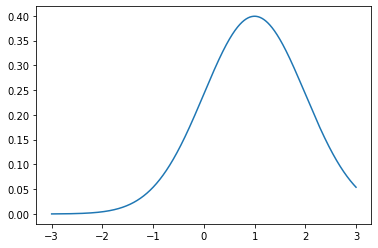

In [36]:
x=np.linspace(-3,3,100000,'float64')
from matplotlib import pyplot as plt
@vectorize([float64(float64)], target='parallel', fastmath=True)
def gausspdf(x):
    return np.exp(-0.5*(x-1)**2)/(np.sqrt(m.pi*2))  #assuming pdf is normalized in [-inf,inf]
                                                    #if not so, one must divide for new normalization
print(gausspdf(x))
plt.plot(x,gausspdf(x))

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

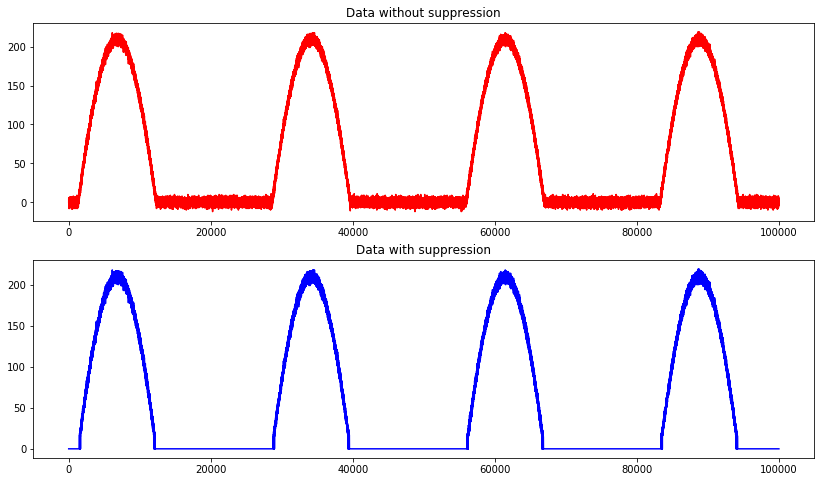

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Data without suppression')
ax1.plot(data,'r')

threshold=15
@jit("int16[:](int16[:])",nopython=True)
def zero_suppress(x):
    for i in range(0,len(x)):
        if (x[i]<threshold):
            x[i]=0
    return x

SupprData=zero_suppress(data)
ax2 =  fig.add_subplot(2, 1, 2)
ax2.set_title('Data with suppression')
ax2.plot(SupprData,'b')

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [62]:
X = np.random.rand(3,3).astype('f')
Y = np.random.rand(3,3).astype('f')

@jit("float32[:,:](float32[:,:],float32[:,:])",nopython=True)
def SigmKern(x,y):
    a=1
    c=0
    return np.tanh(a*((x.transpose())*y)+c)
    
print(SigmKern(X,Y))

[[0.52107304 0.08712548 0.43425688]
 [0.41766468 0.03098346 0.07176477]
 [0.28462708 0.03969412 0.20555119]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [12]:
#data = np.ones((256,256,256))  #using smaller dim objects, because of CUDA bug in simulations
#threadsperblock = (64, 32, 16)
data = np.random.rand(32,32,32)*m.pi #getting every possible value of cos (periodicity)
threadsperblock = (8, 8, 8)
blockspergrid_x = int(m.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(m.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y,blockspergrid_z)

# CUDA kernel
@cuda.jit
def double_kernel(io_array):
    row, col, depth = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and depth < io_array.shape[2]:
        io_array[row][col][depth] = np.cos(io_array[row][col][depth])
        

double_kernel[blockspergrid, threadsperblock](data)
print(data)        

[[[-0.99233503  0.34325123 -0.34210815 ... -0.43245481 -0.69012901
   -0.86318046]
  [-0.83501681 -0.66396889 -0.80121376 ...  0.94553249 -0.57799007
   -0.33392688]
  [ 0.95021048 -0.78377051 -0.89047544 ...  0.96007769  0.80520122
    0.55913594]
  ...
  [-0.40156552 -0.91482637  0.66165021 ...  0.23129281 -0.53573524
   -0.64380984]
  [-0.63014388  0.56185965  0.36882137 ...  0.19859751 -0.99989289
   -0.92583524]
  [-0.61792607 -0.65483952  0.59344953 ...  0.89944522 -0.54814195
    0.82890792]]

 [[ 0.54576135  0.68459165  0.73244412 ...  0.64127528 -0.45552782
   -0.89636711]
  [ 0.4780742  -0.04576233  0.85425667 ... -0.77913861  0.98889269
   -0.08725548]
  [ 0.2249334   0.98982343  0.81680133 ...  0.6825342   0.1280841
   -0.99464808]
  ...
  [-0.84205003 -0.15456185 -0.95730449 ... -0.39054893 -0.42437387
   -0.99116211]
  [ 0.06294238  0.30128701  0.1327729  ... -0.66476836  0.67327585
    0.59471176]
  [ 0.56715123  0.72242679  0.4010478  ... -0.89754907 -0.98494856
    0.0

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [21]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(1,10,size=(24,12))
B = np.random.randint(1,10,size=(12,12))  #supposing the 22 in the exercise text is a typo

# Configure the blocks
threadsperblock = (6,6)
blockspergrid_x = int(m.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid  = (blockspergrid_x, blockspergrid_y)

C=np.empty((24,12))
matmul[blockspergrid, threadsperblock](A,B,C)
print(C)    

[[488. 416. 412. 434. 464. 439. 549. 456. 527. 535. 440. 405.]
 [399. 361. 354. 340. 408. 345. 495. 401. 411. 429. 336. 330.]
 [267. 252. 228. 254. 298. 218. 293. 316. 276. 288. 226. 242.]
 [298. 307. 275. 284. 361. 295. 353. 311. 350. 319. 311. 274.]
 [390. 290. 307. 274. 306. 326. 379. 318. 396. 412. 342. 303.]
 [314. 326. 300. 341. 399. 295. 400. 330. 364. 335. 284. 273.]
 [291. 272. 264. 231. 300. 288. 328. 250. 314. 276. 310. 249.]
 [219. 205. 162. 193. 207. 189. 251. 198. 275. 258. 224. 167.]
 [348. 292. 285. 287. 308. 310. 366. 299. 333. 357. 315. 284.]
 [269. 273. 222. 290. 294. 248. 283. 242. 352. 306. 290. 226.]
 [347. 295. 354. 288. 331. 366. 383. 337. 356. 373. 305. 331.]
 [333. 288. 316. 264. 311. 342. 383. 281. 320. 315. 330. 287.]
 [384. 325. 322. 361. 387. 343. 458. 357. 415. 420. 345. 299.]
 [333. 290. 318. 285. 297. 323. 376. 296. 362. 346. 308. 285.]
 [344. 300. 307. 293. 344. 279. 395. 349. 351. 359. 279. 271.]
 [341. 287. 321. 320. 349. 306. 400. 345. 360. 378. 265